First I imported all functions I created to make the code simpler.

In [1]:
from radiocore import *

Functions useful for my radio astronomy reasearch


Then I opened the two main datasets I'd be working with.

The Gaia dataset has information about stars in the region of the sky where the radio datawas taken.

The Radio dataframe has the flux density data and the RA and Dec.
These Objects are not necessarily all stars.

In [27]:
gaia = pd.read_csv(r'data/gaia_stars_MKD2.csv')
gaia = gaia.sort_values(by=['ra','dec'], ascending=[True,False]) #organize the dataframe by RA and Dec
radio = pd.read_csv(r'data/DEEP2radioCatalog.csv')

Reduced the dataframe to data I could work with.

In [18]:
gaia = gaia[(gaia.parallax==gaia.parallax)] # dropping the rows where parallax = NaN
gaia = gaia[(gaia.bp_rp==gaia.bp_rp)] # dropping rows where bp_rp = NaN
gaia = gaia[(gaia.phot_g_mean_mag==gaia.phot_g_mean_mag)] # dropping rows where phot_g_mean_mag = NaN
# gaia.dropna(subset=['parallax','bp_rp','phot_g_mean_mag']) # did not work
# look for a good signal (small variability = less chance of it being a variable star)
gaia = gaia[(gaia.phot_g_mean_flux>5*gaia.phot_g_mean_flux_error)] # keeping only rows with a phot_g_mean_flux SNR > 5
gaia = gaia[(gaia.parallax>5*gaia.parallax_error)] # keeping only rows with a parallax SNR > 5
# we only keep stars with a small error in their RA and Dec, otherwise their position might be inacurate, which is important when crossmatching datasets
gaia = gaia[gaia.ra_error<1] 
gaia = gaia[gaia.dec_error<1].reset_index(drop=True)

Crossmatched the two datasets

In [19]:
radioRA = np.array([str(radio.iloc[i]['RAh'])+':'+str(radio.iloc[i]['RAm'])+':'+str(radio.iloc[i]['RAs']) for i in range(len(radio))])
radioDec = np.array([str(radio.iloc[i]['DE-'])+str(radio.iloc[i]['DEd'])+':'+str(radio.iloc[i]['DEm'])+':'+str(radio.iloc[i]['DEs']) for i in range(len(radio))])
radioCoords = SkyCoord(radioRA,radioDec,unit=(u.hourangle,u.deg))
radioRA_e = np.array(['0:0:'+str(radio.iloc[i]['eRA']) for i in range(len(radio))])
radioDec_e = np.array(['0:0:'+str(radio.iloc[i]['eDE']) for i in range(len(radio))])
radioCoords_e = SkyCoord(radioRA_e,radioDec_e,unit=(u.hourangle,u.deg))
gaiaCoords = SkyCoord(np.array(gaia.ra),np.array(gaia.dec),unit=(u.deg,u.deg))
gaiaCoords_e = SkyCoord(np.array(gaia.ra_error),np.array(gaia.dec_error),unit=(u.milliarcsecond,u.milliarcsecond))
idx, d2d, d3d = gaiaCoords.match_to_catalog_sky(radioCoords)

Combined everything into one dataframe

Text(0, 0.5, 'number of matches with said arcsec difference')

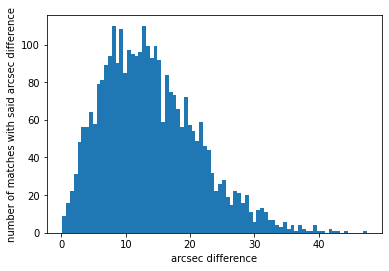

In [20]:
GR_match = gaia.copy()
GR_match['gaia_ra'] = GR_match.ra
GR_match['gaia_dec'] = GR_match.dec
GR_match['gaia_ra_e'] = GR_match.ra_error
GR_match['gaia_dec_e'] = GR_match.dec_error
radio_ra = []
radio_ra_e = []
radio_dec = []
radio_dec_e = []
S1 = []
S1_e = []
Group = []
for i in idx:
    radio_ra.append(radioCoords[i].ra.value)
    radio_ra_e.append(radioCoords_e[i].ra.value)
    radio_dec.append(radioCoords[i].dec.value)
    radio_dec_e.append(radioCoords_e[i].dec.value)
    S1.append(radio['S1.266'][i])
    S1_e.append(radio['e_S1.266'][i])
    Group.append(radio['Group'][i])
GR_match['radio_ra'] = radio_ra
GR_match['radio_dec'] = radio_dec
GR_match['radio_ra_e'] = radio_ra_e
GR_match['radio_dec_e'] = radio_dec_e
GR_match['d2d'] = d2d.value*60*60
GR_match['d3d'] = d3d.value
GR_match['1.266GHz'] = S1
GR_match['1.266GHz_e'] = S1_e
GR_match['Group'] = Group
GR_match = GR_match.reset_index(drop=True)
GR_match = GR_match.drop(['ra','ra_error','dec','dec_error','ruwe','pseudocolour_error','has_xp_continuous', 'has_xp_sampled', 'has_rvs',
       'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot','has_mcmc_msc','l','b'],axis=1)
plt.hist(GR_match.d2d,bins=80)
plt.xlabel('arcsec difference')
plt.ylabel('number of matches with said arcsec difference')

Using the formula

$$ 5 \log \frac{d}{\text{10 pc}} = m_{I,0} - M_{I,0}$$

we find absolute magnitude M

m = 'phot_g_mean_mag' (apparent mag)

$ d = \frac{1000}{'parallax'} $ (parallax measured in milli arcsec)

Text(0, 0.5, 'number of matches with said arcsec difference')

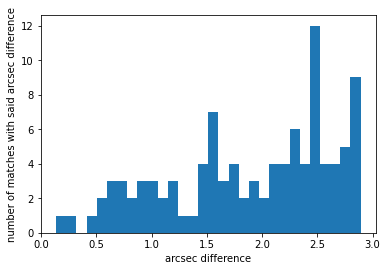

In [21]:
GR_close = GR_match[d2d<2.9*u.arcsec] # only consider matches that are less than 2.9 arcsec away
GR_close = GR_close.reset_index(drop=True)
d = 1000/np.array(GR_close.parallax)
M = np.array(GR_close.phot_g_mean_mag) - 5*np.log10(np.abs(d/10))
GR_close['MG'] = M
plt.hist(GR_close.d2d,30)
plt.xlabel('arcsec difference')
plt.ylabel('number of matches with said arcsec difference')

Important columns:

classprob_dsc_combmod_galaxy : probability of being a galaxy (>10^(-7)%)

classprob_dsc_combmod_quasar : probability of being a quasar (>10^(-7)%)

non_single_star : 0 for single star

                  1 for astrometric binary

                  2 for spectroscopic binary
                  
                  3 for eclipsing binary

in_galaxy_candidates : True / False

in_qso_candidates : True /  False

In [8]:
# find rows that have some variable flag
GR_close.phot_variable_flag[~(GR_close.phot_variable_flag=='NOT_AVAILABLE')]

39    VARIABLE
Name: phot_variable_flag, dtype: object

In [9]:
# find rows that are Quasar candidates
GR_close.in_qso_candidates[GR_close.in_qso_candidates==True]

Series([], Name: in_qso_candidates, dtype: bool)

In [10]:
# find rows that are Galaxy candidates
GR_close.in_galaxy_candidates[GR_close.in_galaxy_candidates==True]

Series([], Name: in_galaxy_candidates, dtype: bool)

In [11]:
# find rows that are not single stars according to Gaia
GR_close.non_single_star[~(GR_close.non_single_star==0)]

Series([], Name: non_single_star, dtype: int64)

In [12]:
# find rows that have higher probability of being a Quasar
GR_close.classprob_dsc_combmod_quasar[GR_close.classprob_dsc_combmod_quasar>0.0000001]

82    0.000296
Name: classprob_dsc_combmod_quasar, dtype: float64

In [14]:
# find rows that have higher probability of being a Galaxy
GR_close.classprob_dsc_combmod_galaxy[GR_close.classprob_dsc_combmod_galaxy>0.0000001]

36    5.303526e-05
90    9.563470e-07
Name: classprob_dsc_combmod_galaxy, dtype: float64

Plots

Start with an HR Diagram

C:\Users\juand\AppData\Local\Temp\ipykernel_13948\92950150.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels([3000,4000,5000,6000,7000,8000,9000])


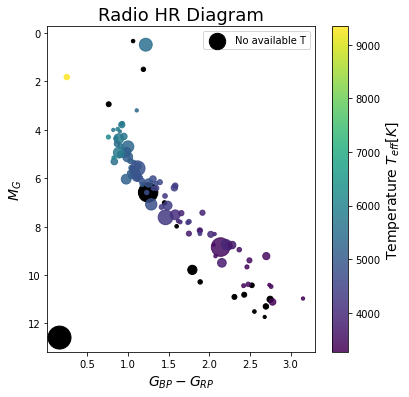

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
cond = GR_close.teff_gspphot==GR_close.teff_gspphot
# no gravity values:
s = np.array(GR_close['1.266GHz'][~cond])
plt.scatter(GR_close.bp_rp[~cond],GR_close.MG[~cond], s=s, color='k', zorder=1)
# gravity map:
s = np.array(GR_close['1.266GHz'][cond])
scatter = plt.scatter(GR_close.bp_rp[cond],GR_close.MG[cond], alpha=0.85, s=s, c=GR_close.teff_gspphot[cond], zorder=2)

ax.invert_yaxis()
ax.set_xlabel('$G_{BP}-G_{RP}$',size=14)
ax.set_ylabel('$M_G$',size=14)
cb = fig.colorbar(scatter)
cb.set_label("Temperature $T_{eff} [K]$",size=14)
cb.set_ticklabels([3000,4000,5000,6000,7000,8000,9000])
plt.title("Radio HR Diagram",size=18)
plt.tick_params(axis="x")
plt.tick_params(axis="y")
plt.legend(['No available T'])

Fits file and Gaia Matches

In [17]:
radio_fits = fits.open('data/DEEP2_Take11_HWPB.fits')[0]
print(radio_fits)
wcs =  WCS(radio_fits.header)

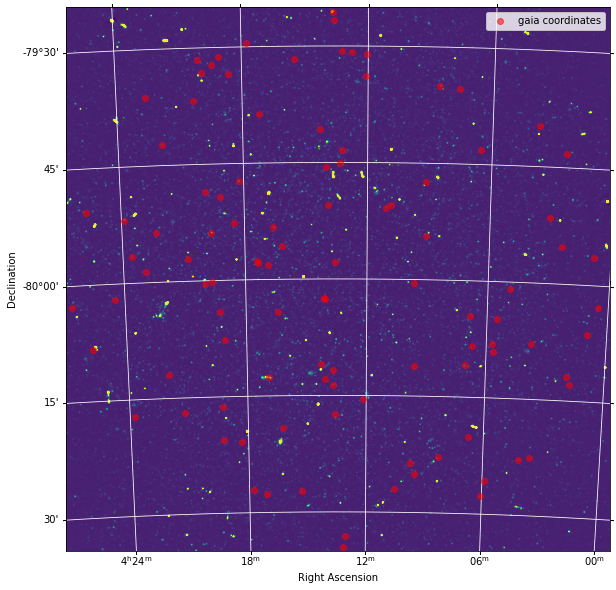

In [18]:
fig = plt.figure(figsize=[10,10])
ax = plt.subplot(111, projection=wcs)
plt.subplot(projection=wcs)
plt.imshow(radio_fits.data, vmin=-2.e-5, vmax=2.e-4, origin='lower')
plt.grid(color='white', ls='solid')

ax.plot_coord(SkyCoord(GR_close.gaia_ra*u.deg, GR_close.gaia_dec*u.deg), "ro", alpha=0.55, label='gaia coordinates')

for x,y,xe,ye in zip(GR_close.gaia_ra,GR_close.gaia_dec,GR_close.gaia_ra_e/3600000,GR_close.gaia_dec_e/360000000):
    rect = plt.Rectangle((x-xe, y-ye), 2*xe, 2*ye, edgecolor='red', facecolor='none', alpha=0.55, linewidth=2,transform=ax.get_transform('world'))
    ax.add_patch(rect)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.legend()
plt.show()

Source Selection

Getting rid of variable, binary, chemically peculiar, and Dwarf candidates

In [165]:
# Crossmatching with Simbad we obrain a Chemically Peculiar and a White Dwarf star
Simbad.reset_votable_fields()
Simbad.add_votable_fields('cel','coo_qual','coo_wavelength','dim','dim_qual','dim_wavelength',
'distance','einstein','fe_h','gcrv','gen','hbet','hbet1','hgam','iras','irc','jp11','mesplx',
'mk','otype','otypes','plx','plx_error','plx_prec','plx_qual','posa','rot','rv_value','rvz_qual',
'rvz_radvel','rvz_type','rvz_wavelength','sp','sp_nature','sptype','td1','ubv','uvby','uvby1','v*','z_value')
simbad_table = Simbad.query_region(coord.SkyCoord("4h13m26.4s -80d0m0s", frame='icrs'), radius='0d35m0s').to_pandas()
GRgaiaCoords = SkyCoord(GR_close['gaia_ra'],GR_close['gaia_dec'],unit=(u.deg,u.deg))
simbadCoords = SkyCoord(np.array(simbad_table['RA']),np.array(simbad_table['DEC']),unit=(u.hour,u.deg))

In [20]:
idx, d2d, d3d = GRgaiaCoords.match_to_catalog_sky(simbadCoords)
GRS_close = GR_close[d2d<2.9*u.arcsec].reset_index(drop=True).drop(['pseudocolour','pmra','pmra_error','pmdec','pmdec_error','Group','d2d','d3d'],axis=1)
idx_close = idx[d2d<2.9*u.arcsec]
d2d_close = d2d[d2d<2.9*u.arcsec]
simbad_small = simbad_table.iloc[idx_close].reset_index(drop=True)
GRS = pd.concat([GRS_close, simbad_small], axis=1)
GRS[['gaia_ra','gaia_dec','1.266GHz','OTYPE','MG','bp_rp','Fe_H_Teff', 'Fe_H_log_g', 'Fe_H_Fe_H', 'Fe_H_CompStar','COO_BIBCODE']]

,gaia_ra,gaia_dec,1.266GHz,OTYPE,MG,bp_rp,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_CompStar,COO_BIBCODE
0,64.223861,-79.968741,12.3,Star,0.336960,1.062096,5146,2.4463,-0.847,Sun,2020yCat.1350....0G
1,64.588789,-80.347777,16.9,ChemPec*,4.301011,0.758354,5951,4.1558,-1.455,Sun,2020yCat.1350....0G
2,64.776019,-79.520866,30.0,Star,1.824520,0.245916,0,NaN,NaN,,2020yCat.1350....0G
3,64.906067,-79.897131,527.0,WhiteDwarf_Candidate,12.583438,0.156826,0,NaN,NaN,,2020yCat.1350....0G
4,65.964629,-79.866257,24.1,Star,2.945950,0.761892,6042,3.8517,-0.429,Sun,2020yCat.1350....0G


Use Vizier to obtain more data about those stars

In [157]:
V = Vizier(columns=['RAJ2000', 'DEJ2000', 'RAgaia', 'DEgaia', 'jmag', "W1mag", "W2mag", "W3mag", "W4mag", "Jmag"])
simbad0 = V.query_region(coord.SkyCoord("4h16m53.7s -79d58m7.47s", frame='icrs'), radius='0d00m2.9s')
simbad1 = V.query_region(coord.SkyCoord("4h18m21.3s -80d20m52s", frame='icrs'), radius='0d00m2.9s')
simbad2 = V.query_region(coord.SkyCoord("4h19m6.2s -79d31m15.12s", frame='icrs'), radius='0d00m2.9s')
simbad3 = V.query_region(coord.SkyCoord("4h19m37.4s -79d53m49.67s", frame='icrs'), radius='0d00m2.9s')
simbad4 = V.query_region(coord.SkyCoord("4h23m51.5s -79d51m58.53s", frame='icrs'), radius='0d00m2.9s')

In [158]:
simbad0 = pd.concat([simbad0[i].to_pandas() for i in range(len(simbad0)) if len(simbad0[i])==1], axis=1).dropna(axis='columns', how='all')
simbad0 = simbad0.loc[:,         ~simbad0.columns.duplicated()]
simbad0 = simbad0.loc[:, np.array(simbad0.apply(lambda x: x != ''))[0]]
simbad1 = pd.concat([simbad1[i].to_pandas() for i in range(len(simbad1)) if len(simbad1[i])==1], axis=1).dropna(axis='columns', how='all')
simbad1 = simbad1.loc[:,         ~simbad1.columns.duplicated()]
simbad1 = simbad1.loc[:, np.array(simbad1.apply(lambda x: x != ''))[0]]
simbad2 = pd.concat([simbad2[i].to_pandas() for i in range(len(simbad2)) if len(simbad2[i])==1], axis=1).dropna(axis='columns', how='all')
simbad2 = simbad2.loc[:,         ~simbad2.columns.duplicated()]
simbad2 = simbad2.loc[:, np.array(simbad2.apply(lambda x: x != ''))[0]]
simbad3 = pd.concat([simbad3[i].to_pandas() for i in range(len(simbad3)) if len(simbad3[i])==1], axis=1).dropna(axis='columns', how='all')
simbad3 = simbad3.loc[:,         ~simbad3.columns.duplicated()]
simbad3 = simbad3.loc[:, np.array(simbad3.apply(lambda x: x != ''))[0]]
simbad4 = pd.concat([simbad4[i].to_pandas() for i in range(len(simbad4)) if len(simbad4[i])==1], axis=1).dropna(axis='columns', how='all')
simbad4 = simbad4.loc[:,         ~simbad4.columns.duplicated()]
simbad4 = simbad4.loc[:, np.array(simbad4.apply(lambda x: x != ''))[0]]

In [107]:
J=np.array([simbad0.Jmag,simbad1.Jmag,simbad2.Jmag,simbad4.Jmag])
W1=np.array([simbad0.W1mag,simbad1.W1mag,simbad2.W1mag,simbad4.W1mag])
W2=np.array([simbad0.W2mag,simbad1.W2mag,simbad2.W2mag,simbad4.W2mag])
W3=np.array([simbad0.W3mag,simbad1.W3mag,simbad2.W3mag,simbad4.W3mag])
W4=np.array([simbad0.W4mag,simbad1.W4mag,simbad2.W4mag,simbad4.W4mag])

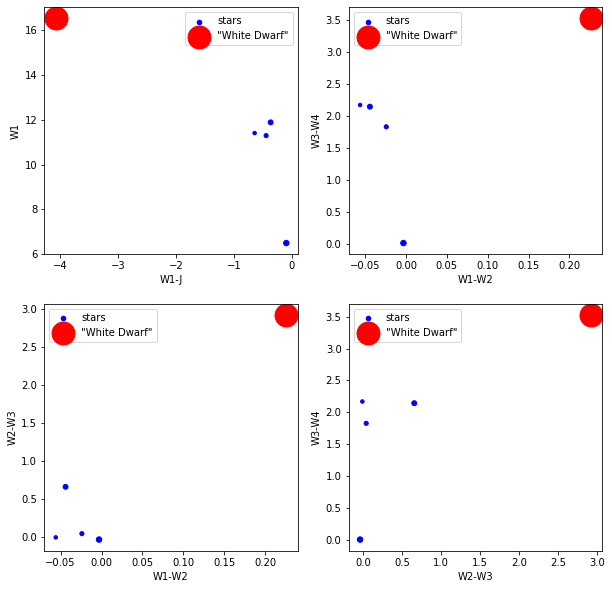

In [110]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
fig.set_facecolor('white')
s1 = list(GRS['1.266GHz'][:3])+[GRS['1.266GHz'][4]]
s2 = np.int0(GRS['1.266GHz'][3])

ax[0][0].scatter(W1-J,W1,label='stars',c='b',s=s1)
ax[0][0].scatter(simbad3.W1mag-simbad3.jmag,simbad3.W1mag,c='r', label='"White Dwarf"',s=s2)
ax[0][0].set_xlabel('W1-J')
ax[0][0].set_ylabel('W1')
ax[0][0].legend()

ax[0][1].scatter(W1-W2,W3-W4,label='stars',c='b',s=s1)
ax[0][1].scatter(simbad3.W1mag-simbad3.W2mag,simbad3.W3mag-simbad3.W4mag,c='r', label='"White Dwarf"',s=s2)
ax[0][1].set_xlabel('W1-W2')
ax[0][1].set_ylabel('W3-W4')
ax[0][1].legend()

ax[1][0].scatter(W1-W2,W2-W3,label='stars',c='b',s=s1)
ax[1][0].scatter(simbad3.W1mag-simbad3.W2mag,simbad3.W2mag-simbad3.W3mag,c='r', label='"White Dwarf"',s=s2)
ax[1][0].set_xlabel('W1-W2')
ax[1][0].set_ylabel('W2-W3')
ax[1][0].legend()

ax[1][1].scatter(W2-W3,W3-W4,label='stars',c='b',s=s1)
ax[1][1].scatter(simbad3.W2mag-simbad3.W3mag,simbad3.W3mag-simbad3.W4mag,c='r', label='"White Dwarf"',s=s2)
ax[1][1].set_xlabel('W2-W3')
ax[1][1].set_ylabel('W3-W4')
ax[1][1].legend()

These plots confirm that it is indeed a whit dwarf

In [233]:
GRP = pd.read_csv(r'data/gaiaRadio_wPhotometry.csv')

condition = ((GRP.Group != 'G25') & (GRP['1.266GHz'] < 520) & (GRP.phot_variable_flag=='NOT_AVAILABLE')) # Drop the white dwarf, chemically peculiar, and variable star
GRPhot = GRP[condition] 
GRPhot.reset_index(drop=True, inplace=True)

mags = {}
for col in GRPhot.columns:
    if 'mag' in col:
        if col not in ['phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']:
            mags[col] = np.array(GRPhot[col])
errs = {}
for col in GRPhot.columns:
    if 'err' in col:
        if col not in ['parallax_error','pmra_error','pmdec_error','phot_g_mean_error','phot_bp_mean_error','phot_rp_mean_error','phot_g_mean_flux_error','phot_bp_mean_flux_error','phot_g_mean_flux_error','phot_bp_mean_flux_error.1']:
            errs[col] = np.array(GRPhot[col])

for mkey, ekey in zip(mags.keys(),errs.keys()):
    mags[mkey] = np.where(np.abs(mags[mkey])>30,np.nan,mags[mkey])
    errs[ekey] = np.where(np.abs(mags[mkey])>30,np.nan,errs[ekey])

nanmag = np.isnan((mags['ch1mag'] - mags['Jmag']))
nanTemp = ~np.array(GRPhot.teff_gspphot==GRPhot.teff_gspphot)
lowT = np.array(GRPhot.teff_gspphot<3500)
highT = np.array(GRPhot.teff_gspphot>7200)

We plot the Star Locus suggested by Davenport et a (2013) to visualize the confirmed single stars

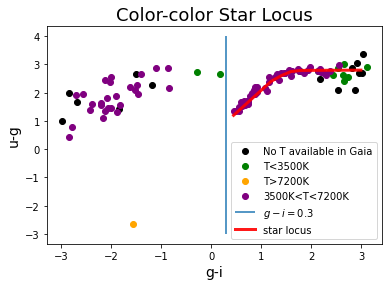

In [237]:
plt.figure(facecolor='white')
plt.scatter(mags['gmag'][nanTemp] - mags['imag'][nanTemp], mags['umag'][nanTemp] - mags['gmag'][nanTemp],c='k',label='No T available in Gaia')
plt.scatter(mags['gmag'][lowT] - mags['imag'][lowT], mags['umag'][lowT] - mags['gmag'][lowT],c='g',label='T<3500K')
plt.scatter(mags['gmag'][highT] - mags['imag'][highT], mags['umag'][highT] - mags['gmag'][highT],c='orange',label='T>7200K')
plt.scatter(mags['gmag'][~(nanTemp+lowT+highT)] - mags['imag'][~(nanTemp+lowT+highT)], mags['umag'][~(nanTemp+lowT+highT)] - mags['gmag'][~(nanTemp+lowT+highT)],c='purple',label='3500K<T<7200K')
plt.vlines(0.3,ymin=-3,ymax=4, label='$g - i=0.3$')
plt.tick_params(axis="x")
plt.tick_params(axis="y")
plt.xlabel('g-i',size=14)
plt.ylabel('u-g',size=14)
plt.title("Color-color Star Locus",size=18)
plt.plot([0.45,1.2,1.4,1.6,1.8,3],[1.2,2.4,2.6,2.75,2.79,2.8],lw=3,c='r',alpha=0.9,label='star locus')
plt.legend()

In [238]:
# only use stars with g-i color greater than 0.3 (those that are on the locus)
GRPhot = GRPhot[(GRPhot.gmag-GRPhot.imag)>0.3].reset_index(drop=True)

We did another Gaia Query to obtain more data for those stars and be able to obtain metallicity

In [239]:
Allcols = pd.read_csv(r'data/gaia_stars_MKD2_all.csv')
merged_df = Allcols.merge(GRPhot, on='source_id', how='inner')
for col in merged_df.columns:
    if '_x' in col:
        merged_df.rename(columns={col: col[:-2]}, inplace=True)
d = 1000/np.array(merged_df.parallax)
M = np.array(merged_df.phot_g_mean_mag) - 5*np.log10(np.abs(d/10))
merged_df['mg_gspphot'] = M
flts = ['umag','gmag','rmag','imag','zmag','Ymag','Jmag','ch1mag','ch2mag'] #if these magnitudes are too large, replace by nan
for f in flts:
    for col in merged_df.columns:
        if f in col:
            for i in range(len(merged_df)):
                if (merged_df[col][i]>30)|(merged_df[col][i]<-30):
                    merged_df[col][i]=np.nan
                    merged_df[col[:-3]+'err'][i]=np.nan

C:\Users\juand\AppData\Local\Temp\ipykernel_13948\1489661541.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[col][i]=np.nan
C:\Users\juand\AppData\Local\Temp\ipykernel_13948\1489661541.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[col[:-3]+'err'][i]=np.nan


Gaia offers a code that calculates metallicity for stars.

Code is not accurate for regions with high extintion.

We confirmed that our region has low to no extintion.

In [246]:
from gdr3apcal.src.gdr3apcal import calibration as gcal
calib = gcal.GaiaDR3_GSPPhot_cal()
merged_df['FeH_cal'] = calib.calibrateMetallicity(merged_df)
merged_df.to_csv('data/GRPhotMet.csv',index=False)

C:\Users\juand\Research\CARNEGIE\RadioAstronomy\gdr3apcal\src\gdr3apcal\models\mars_mh.py: 682ec200c6392244c50e5659a9ff9923f6dd1f801e33fabb40a9fa93ba58c031
Model mh (C:\Users\juand\Research\CARNEGIE\RadioAstronomy\gdr3apcal\src\gdr3apcal\models\mars_mh.py) input file does not match the configuration.Expecting bd102a2b38e161e6c770650e021d2d8696542e2bddd411d0a590fe28f24030fa, got 682ec200c6392244c50e5659a9ff9923f6dd1f801e33fabb40a9fa93ba58c031
Automatically adding "cos(b)" from "b" [assuming degrees].
Automatically adding "cos(b)" from "b" [assuming degrees].


After finding metalicity using Gaia code, we checked for missmatches in the i-band

Then we used the POLLUX database to obtain temperature, metallicty and logg of the stars by SED fitting.

The SED data is the average of the best 5 matched results.

In [2]:
with open('data/GRPhotMetIband.pickle', 'rb') as f:
    GRPMI = pickle.load(f)

filterwave_VIS = [3543, 4770, 6231, 7625, 9134, 10500]
filterwave_VIS_IR = [3543, 4770, 6231, 7625, 9134, 10500, 12500]
filternames_VIS_IR = ['umag', 'gmag', 'rmag', 'imag', 'zmag','Ymag','Jmag']
filternames_VIS = ['umag', 'gmag', 'rmag', 'imag', 'zmag','Ymag']
errornames_VIS_IR = ['uerr', 'gerr', 'rerr', 'ierr', 'zerr','Yerr','Jerr']
errornames_VIS = ['uerr', 'gerr', 'rerr', 'ierr', 'zerr','Yerr']
nu2lambda_VIS_IR = 2.99792458*(10**18)/(np.array(filterwave_VIS_IR)**2)
nu2lambda_VIS = 2.99792458*(10**18)/(np.array(filterwave_VIS)**2)

This is the final distribution of stars in an HR diagram

(0.0, 3.2)

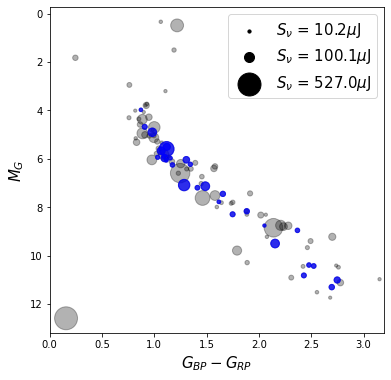

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.set_facecolor('white')
s = np.array(GR_close['1.266GHz'])
plt.scatter(GR_close.bp_rp,GR_close.MG, alpha=0.3, s=s, color='k', zorder=1)
s = np.array(GRPMI['1.266GHz'])
ax.scatter(GRPMI.bp_rp,GRPMI.MG, alpha=0.75, s=s, color='b', zorder=2)

s=[min(GR_close['1.266GHz']),100.1,max(GR_close['1.266GHz'])]
for i in s:
    ax.scatter(-1,6,s=i,label='$S_\\nu$ = {Fv}$\\mu$J'.format(Fv=str(i)),color='k')

ax.legend(prop = {"size": 15})
ax.invert_yaxis()
ax.set_xlabel('$G_{BP}-G_{RP}$',size=15)
ax.set_ylabel('$M_G$',size=15)
ax.set_xlim(0,3.2)

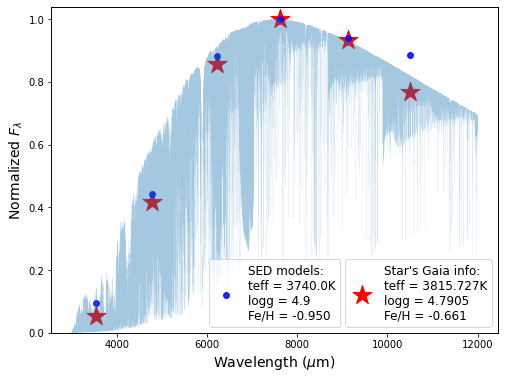

In [252]:
rowi = 5
jjj = 2

fig, ax = plt.subplots(figsize=(8,6))
fig.set_facecolor('white')
ax2 = ax.twinx()
bestf = GRPMI.iloc[rowi]['BESTFITS'][jjj]
ffn = bestf['filtersfluxnorm']
match = recover_stars(['POLLUX/vi'])['POLLUX/vi'][0]
wv = match['wavelength']
fx = np.array(match['flux'])
fx = fx/max(fx)

starstring = "Star's Gaia info:\nteff = {teff}K\nlogg = {logg}\nFe/H = {FeH:.3f}".format(teff=GRPMI['teff_gspphot'][rowi],logg=GRPMI['logg_gspphot'][rowi],FeH=GRPMI['FeH_cal'][rowi])
modelstring = "SED models:\nteff = {teff}K\nlogg = {logg}\nFe/H = {FeH:.3f}".format(teff=GRPMI['avg_teff'].iloc[5],logg=GRPMI['avg_logg'].iloc[5],FeH=GRPMI['avg_Fe/H'].iloc[rowi])
flux0 = magAB2flux(np.array([GRPMI[fn][rowi] for fn in filternames_VIS]),units='cgs')*nu2lambda_VIS
fluxerr0 = magAB2flux(np.array([GRPMI[fn][rowi]-GRPMI[fen][rowi] for fn,fen in zip(filternames_VIS,errornames_VIS)]),units='cgs')*nu2lambda_VIS-flux0
flux0norm = np.array(flux0)/max(flux0)
fluxerr0norm = np.array(fluxerr0)/max(flux0)


ax.scatter(filterwave_VIS,flux0norm,alpha=1,s=400,c='r',marker='*',label=starstring)
ax.errorbar(filterwave_VIS,y=flux0norm,yerr=fluxerr0norm,ls='none',c='red')
ax.legend(loc=4,fontsize=12)
ax.set_xlabel('Wavelength ($\\mu$m)',size=14)
ax.set_ylabel('Normalized $F_\\lambda$',size=14)
ax.set_ylim(0,1.04)
ax2.scatter(filterwave_VIS,ffn,alpha=0.85,s=35,c='b',marker='o',label=modelstring)
ax2.legend(loc=8,fontsize=12)
ax2.set_ylim(0,1.04)

ax2.get_yaxis().set_visible(False)

# plt.text(3400,0.95,'$\\chi^2={chi:.2f}$'.format(chi=bestf['chi2']),size=17,c='b')

plt.plot(np.array(wv),fx,alpha=0.4,linewidth=0.1)

Relationships found:

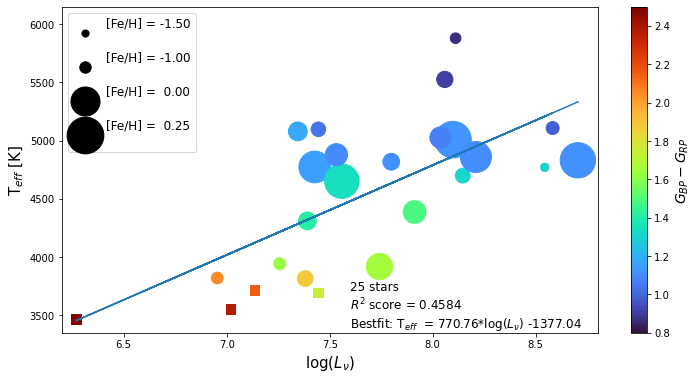

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.set_facecolor('white')

size = 6.5**(1.5*np.abs(min(GRPMI['avg_Fe/H']))+np.array(GRPMI['FeH_cal']))
rf = GRPMI['1.266GHz']
rf_e = GRPMI['1.266GHz_e']
d = 1000/GRPMI['parallax']
x = np.array(np.log10(rf*(d**2)))
xerr = np.array(np.log10((rf+rf_e)*(d**2)))-x
y = np.array(GRPMI['teff_gspphot'])
yerr1 = np.array(GRPMI['std_teff'])*0
teffstd = np.std(GRPMI['teff_gspphot']-GRPMI['avg_teff'])
yerr = (yerr1**2 + teffstd**2)**0.5

# size marker legend
FeHlist = [-1.5,-1,0,0.25]
FeHlistsize = 6.5**(1.5*np.abs(min(GRPMI['avg_Fe/H']))+np.array(FeHlist))
FeHlabel = ['-1.50','-1.00',' 0.00',' 0.25']
for i in range(len(FeHlist)):
    plt.scatter(5,4002,s=FeHlistsize[i],c='k',alpha=1,label='[Fe/H] = '+FeHlabel[i]+'\n')
plt.legend(fontsize=12)

# best fit line
# lreg = sp.linregress(x[size==size],np.array(y)[size==size])
lreg = sp.linregress(x[y==y],y[y==y])
slope, intercept, rval, pval, slopeerr = lreg
intercepterr = lreg.intercept_stderr
plt.plot(x,slope*x+intercept)

# scatter plot T vs log(L)
color= np.array(GRPMI['bp_rp'])
scatter = plt.scatter(np.array(x)[size==size],np.array(y)[size==size],marker='o',s=size[size==size],c=color[size==size],cmap='turbo')
scatter2= plt.scatter(np.array(x)[(y==y)&(y<3800)],np.array(y)[(y==y)&(y<3800)],marker='s',s=90,c=color[(y==y)&(y<3800)],cmap='turbo')
# plt.errorbar(x,y,yerr=yerr,linestyle='None',c='k',alpha=0.6) #,xerr=xerr --> flux errors are insignificant and make the plot too crowded
plt.xlabel('log($L_\\nu$)',size=15)
plt.ylabel('T$_{eff}$ [K]',size=15)
plt.xlim([6.2,8.8])
plt.ylim([3350,6150])
# plt.title('Stars in-locus, Gaia data',size=16)
Teff = 'T$_{eff}$'
plt.text(7.6,3400,str(len(x[y==y]))+' stars\n$R^2$ score = {R2:.4f}\nBestfit: '.format(R2=rval**2)+Teff+'  = {slope:.2f}*log($L_\\nu$) {inter:.2f}'.format(slope=slope,inter=intercept),size=12)

# colorbar
cb = fig.colorbar(scatter)
cb.set_label('$G_{BP}-G_{RP}$',size=14)
scatter.set_clim(vmin=0.8, vmax=2.5)
scatter2.set_clim(vmin=0.8, vmax=2.5)

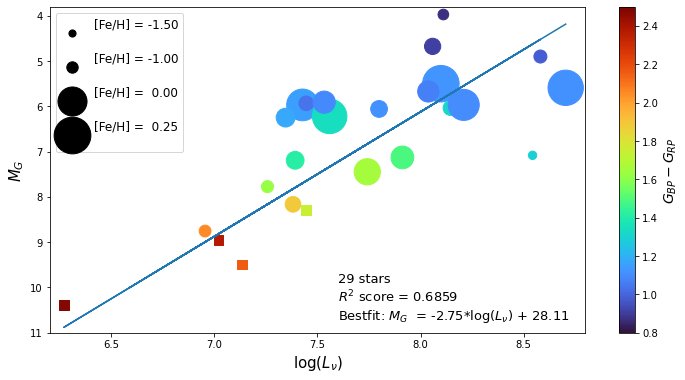

In [26]:
rf = GRPMI['1.266GHz']
rf_e = GRPMI['1.266GHz_e']
d = 1000/GRPMI['parallax']
x=np.log10(rf*(d**2))

FeH  = GRPMI['FeH_cal']
size = 6.5**(1.5*np.abs(min(GRPMI['avg_Fe/H']))+np.array(FeH))
fig, ax = plt.subplots(figsize=(12, 6))
fig.set_facecolor('white')
MG = GRPMI['MG']

# size marker legend
FeHlist = [-1.5,-1,0,0.25]
FeHlistsize = 6.5**(1.5*np.abs(min(GRPMI['avg_Fe/H']))+np.array(FeHlist))
FeHlabel = ['-1.50','-1.00',' 0.00',' 0.25']
for i in range(len(FeHlist)):
    plt.scatter(5,7.6,s=FeHlistsize[i],c='k',alpha=1,label='[Fe/H] = '+FeHlabel[i]+'\n')
plt.legend(fontsize=12,loc=2)

# best fit line
lreg = sp.linregress(x, MG)
slope, intercept, rval, pval, slopeerr = lreg
intercepterr = lreg.intercept_stderr
plt.plot(x,slope*x+intercept)

color= np.array(GRPMI['bp_rp'])
scatter = plt.scatter(x,MG,s=size,c=color,cmap='turbo')
scatter2= plt.scatter(np.array(x)[(y==y)&(y<3800)],MG[(y==y)&(y<3800)],marker='s',s=90,c=color[(y==y)&(y<3800)],cmap='turbo')
plt.xlabel('log($L_\\nu$)', size=15)
plt.ylabel('$M_G$', size=15)
ax.invert_yaxis()
plt.text(7.6,10.7,str(len(MG))+' stars\n$R^2$ score = {R2:.4f}\nBestfit: $M_G$  = {slope:.2f}*log($L_\\nu$) + {inter:.2f}'.format(R2=rval**2,slope=slope,inter=intercept),size=13)
plt.xlim(6.2,8.8)
plt.ylim(11,3.8)
# plt.title('Stars in-locus, Gaia data',size=16)

# colorbar
cb = fig.colorbar(scatter)
cb.set_label('$G_{BP}-G_{RP}$',size=14)
scatter.set_clim(vmin=0.8, vmax=2.5)
scatter2.set_clim(vmin=0.8, vmax=2.5)

In [23]:
ms = 4.86 # magnitude of the Sun
Rs = 69600000000 # Radius of the Sun
Ts = 5772 # Temperature of the Sun
kB = 1.38*(10**(-16)) # Boltzman constant
c  = 29979245800 # speed of light
R_r = ((Ts/GRPMI.teff_gspphot)**2)*((2.512**(ms-GRPMI.MG))**0.5) # Relative Radius
R = R_r*Rs # Radius of the star

Text(0, 0.5, '$M_G$')

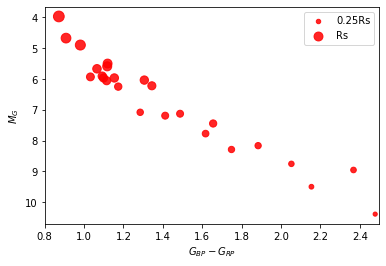

In [3]:
fig,ax = plt.subplots()
fig.set_facecolor('white')
ss = np.array(R_r)*80
plt.scatter(GRPMI.bp_rp,GRPMI.MG, alpha=0.85, s=ss, color='r', zorder=2)

ss = np.array(0.25)*80
plt.scatter(0.7,9, alpha=0.85, s=ss, color='r', zorder=2,label='0.25Rs')
ss = np.array(1)*80
plt.scatter(0.7,9, alpha=0.85, s=ss, color='r', zorder=2,label='Rs')

ax.invert_yaxis()
plt.legend()
plt.xlim(0.8,2.5)
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$M_G$')

$$ S_{\nu} = \frac{2kT_b\nu^2}{c^2}\frac{A}{d^2}\approx 0.1\left(\frac{T_b}{10^6K}\right)\left(\frac{\nu}{1 GHz}\right)^2\left(\frac{r}{10^{11}cm}\right)^2\left(\frac{1pc}{d}\right)^2 mJy (3)$$

$$ B\approx 3.6\times 10^{-7}\frac{\nu}{(1+1.7\times 10^{-10}T_b)^2} [G] (29)$$

Güdel 2002

In [4]:
Sv = GRPMI['1.266GHz']*(10**(-3)) # mJy
d  = 1000/np.array(GRPMI.parallax) # pc
v  = 1.266 # GHz
Tb = (Sv/0.1)*(10**6)*(1/v**2)*(((10**11)/(R))**2)*(d**2) # K
B = 3.6*(10**-7)*(v*10**9)/((1+Tb*1.7*(10**-10))**2) # G

In [5]:
max(Tb)/10**12

16.27469856121976

In [6]:
min(Tb)/10**12

0.44777017238161004

Histograms

Text(0.5, 1.0, 'Flux Density of all sources')

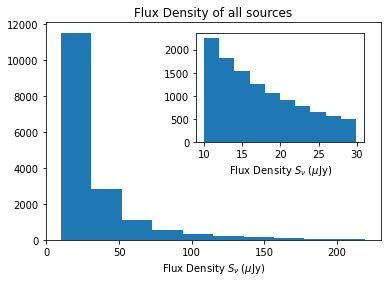

In [15]:
fig,ax = plt.subplots()
fig.set_facecolor('white')
axin = ax.inset_axes([0.45, 0.45, 0.5, 0.5])
axin.hist(radio['S1.266'][radio['S1.266']<30])
axin.set_xlabel('Flux Density $S_{\\nu}$ ($\\mu$Jy)')
plt.hist(radio['S1.266'][radio['S1.266']<220])
plt.xlabel('Flux Density $S_{\\nu}$ ($\\mu$Jy)')
plt.title('Flux Density of all sources')

Text(0.5, 1.0, 'Flux Density of our sources')

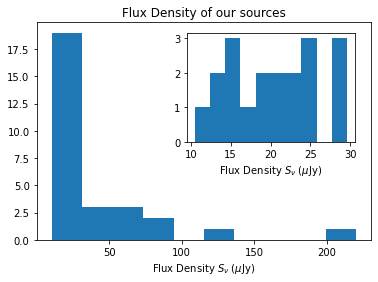

In [16]:
fig,ax = plt.subplots()
fig.set_facecolor('white')
axin = ax.inset_axes([0.45, 0.45, 0.5, 0.5])
axin.hist(Sv[Sv*1000<30]*1000)
axin.set_xlabel('Flux Density $S_{\\nu}$ ($\\mu$Jy)')
plt.hist(Sv*1000)
plt.xlabel('Flux Density $S_{\\nu}$ ($\\mu$Jy)')
plt.title('Flux Density of our sources')

Text(0.5, 0, 'Brightness Temperature $log(T_{b})$')

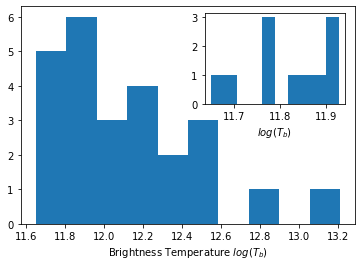

In [12]:
fig,ax = plt.subplots()
fig.set_facecolor('white')
axin = ax.inset_axes([0.55, 0.55, 0.42, 0.42])
axin.hist(np.log10(Tb)[np.log10(Tb)<12])
axin.set_xlabel('$log(T_{b})$')
plt.hist(np.log10(Tb))
plt.xlabel('Brightness Temperature $log(T_{b})$')

Text(0.5, 0, 'Magnetic Field (mG)')

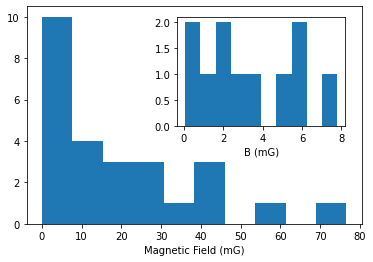

In [144]:
fig,ax = plt.subplots()
fig.set_facecolor('white')
axin = ax.inset_axes([0.45, 0.45, 0.5, 0.5])
axin.hist(B[B<0.01]*1000)
axin.set_xlabel('B (mG)')
plt.hist(B*1000)
plt.xlabel('Magnetic Field (mG)')

Text(0.5, 0, 'u-band magnitude')

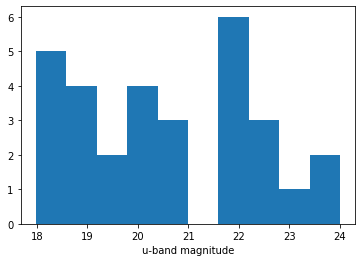

In [92]:
plt.hist(GRPMI.umag)
plt.xlabel('u-band magnitude')

Text(0.5, 0, 'g-band magnitude')

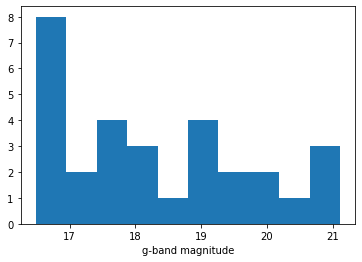

In [93]:
plt.hist(GRPMI.gmag)
plt.xlabel('g-band magnitude')

Text(0.5, 0, 'r-band magnitude')

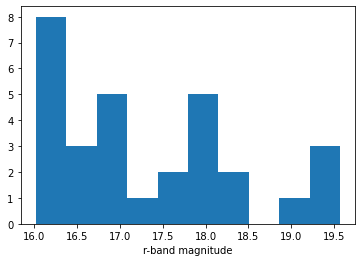

In [94]:
plt.hist(GRPMI.rmag)
plt.xlabel('r-band magnitude')

Text(0.5, 0, 'i-band magnitude')

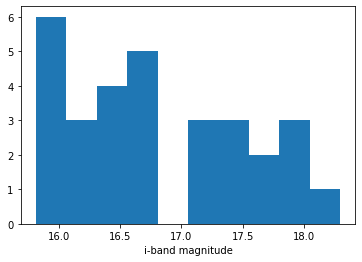

In [95]:
plt.hist(GRPMI.imag)
plt.xlabel('i-band magnitude')

Text(0.5, 0, 'z-band magnitude')

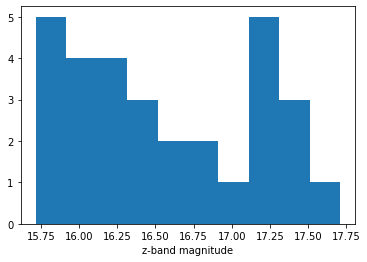

In [96]:
plt.hist(GRPMI.zmag)
plt.xlabel('z-band magnitude')

Text(0.5, 0, 'Y-band magnitude')

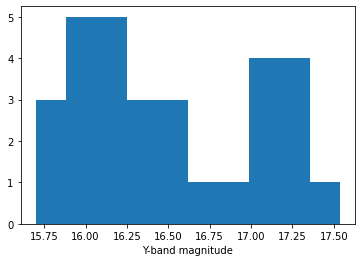

In [97]:
plt.hist(GRPMI.Ymag)
plt.xlabel('Y-band magnitude')

Text(0.5, 0, 'J-band magnitude')

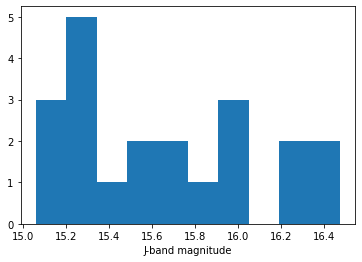

In [98]:
plt.hist(GRPMI.Jmag)
plt.xlabel('J-band magnitude')